In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from sklearn.model_selection import train_test_split
import argparse
from inver_project_model import model_train, model_test
from datasets import *
from projections_methods import get_reducer
from temp_projection_quality_metrics import trustworthiness, calculate_continuity, average_local_error
# from plots import trustworthiness_plot, continuity_plot, average_local_error_plot
from plots import *
from projection_metrics import calculate_projection_metrics, ProjectionMetrics
from utility import *
from sklearn.manifold import TSNE
import seaborn as sns


In [ ]:
def generate_gaussian_clusters(n_gauss=4, n_pts_per_gauss=200, dim=3, centers=None, cluster_spacing=10.0, overlap_factors=None):
    """
    Generate Gaussian clusters with well-separated positioning.
    
    Parameters:
        n_gauss (int): Number of Gaussian clusters.
        n_pts_per_gauss (int): Number of points per cluster.
        dim (int): Dimensionality of the dataset.
        centers (list or None): Custom center positions for each Gaussian.
        cluster_spacing (float): Default spacing between clusters.
        overlap_factors (list or None): List controlling spread of each Gaussian (higher = more spread/overlap).

    Returns:
        D (ndarray): Normalized dataset.
        c (ndarray): Corresponding class labels.
    """
    if centers is None:
        centers = [
            [-cluster_spacing, -cluster_spacing, -cluster_spacing],  # Cluster 1
            [cluster_spacing, cluster_spacing, -cluster_spacing],    # Cluster 2
            [-cluster_spacing, cluster_spacing, cluster_spacing],    # Cluster 3
            [cluster_spacing, -cluster_spacing, cluster_spacing]     # Cluster 4
        ]

    if overlap_factors is None:
        overlap_factors = [0.02, 0.02, 0.02, 0.02]  # Small variance to avoid overlap

    D = np.zeros((n_pts_per_gauss * n_gauss, dim))
    c = np.zeros(n_pts_per_gauss * n_gauss)

    for i in range(n_gauss):
        cov_matrix = np.diag([overlap_factors[i] for _ in range(dim)])
        D[i * n_pts_per_gauss:(i + 1) * n_pts_per_gauss] = np.random.multivariate_normal(
            centers[i], cov_matrix, n_pts_per_gauss
        )
        c[i * n_pts_per_gauss:(i + 1) * n_pts_per_gauss] = i  

    # Normalize dataset
    D = (D - np.min(D, axis=0)) / (np.max(D, axis=0) - np.min(D, axis=0))

    return D, c, centers

## Example 1
### All 4 gaussians are well separated

In [ ]:
# 🎯 Customize Parameters
n_gauss = 4  
n_pts_per_gauss = 200  
cluster_spacing = 15.0   



# Generate Data
D, c, final_centers = generate_gaussian_clusters(n_gauss, n_pts_per_gauss, cluster_spacing=cluster_spacing)


#### Plot 3D (Original High dimensional)

In [ ]:
%matplotlib qt

# # colors = ['r', 'g', 'b']  # Red, Green, Blue
# colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#000000']
# # Create a figure and 3D axis
# fig = plt.figure(figsize=(10, 8))
# ax = fig.add_subplot(projection='3d')

# # Define colors for each Gaussian distribution

# # Loop through each Gaussian to plot points with corresponding color
# for i in range(n_gauss):
#     ax.scatter(D[c == i, 0], D[c == i, 1], D[c == i, 2], color=colors[i], label=f'Gaussian {i+1}')
#     # ax.scatter(D[:,0], D[:,1], D[:,2], c=c)

# # Set labels and title
# ax.set_xlabel('X-axis')
# ax.set_ylabel('Y-axis')
# ax.set_zlabel('Z-axis')
# ax.set_title('3D Scatter Plot of Data Points from Three Gaussian Distributions')

# # Add a legend
# ax.legend()

# # Show the plot
# plt.show()
#####################################################
import plotly.graph_objects as go
import numpy as np

colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#000000']

# Create a 3D scatter plot using Plotly
fig = go.Figure()

# Loop through each Gaussian to plot points with corresponding color
for i in range(n_gauss):
    fig.add_trace(go.Scatter3d(
        x=D[c == i, 0], 
        y=D[c == i, 1], 
        z=D[c == i, 2], 
        mode='markers', 
        marker=dict(color=colors[i], size=5),
        name=f'Gaussian {i+1}'
    ))

# Set labels and title
fig.update_layout(
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    ),
    title='3D Scatter Plot of Data Points from Gaussian Distributions',
    legend=dict(title="Gaussians")
)

# Save the interactive plot to an HTML file
fig.write_html('3d_interactive_plot.html')

# Optionally, display the plot in the Jupyter notebook or browser
# fig.show()

In [ ]:
perplexity = 7

t_sne = TSNE(
    n_components=2,
    perplexity=perplexity,
    init="random",
    random_state=0,
)

low_dm_emb = t_sne.fit_transform(D)
S = low_dm_emb
## Plotting the t-SNE results with the same color scheme
%matplotlib qt

# plt.figure(figsize=(10, 8))
# for i in range(n_gauss):
#     plt.scatter(S[c == i, 0], S[c == i, 1], color=colors[i], label=f'Gaussian {i+1}', edgecolor='k')

# plt.title('t-SNE Visualization of 3D Gaussian Distributions into 2D')
# plt.legend()
# plt.grid(True)
# plt.show()

### Create Grid points

In [ ]:
# Define min and max values
x_min, x_max = np.min(S[:, 0]), np.max(S[:, 0])
y_min, y_max = np.min(S[:, 1]), np.max(S[:, 1])
print(x_min, x_max)
print(y_min, y_max)

# Define grid resolution
num_grid_points = 150

# Generate grid
x_vals = np.linspace(x_min, x_max, num_grid_points)
y_vals = np.linspace(y_min, y_max, num_grid_points)
xx, yy = np.meshgrid(x_vals, y_vals)
print(yy.shape)
print(y_vals.shape)

# %matplotlib qt

# plt.figure(figsize=(10, 8))
# # Visualize the grid on top of the t-SNE data
# plt.scatter(S[:, 0], S[:, 1], c='blue', s=10, label="t-SNE Output")
# plt.scatter(xx, yy, c='red', s=5, label="Grid Points")
# plt.title("2D t-SNE Output with Grid Points")
# plt.xlabel("x")
# plt.ylabel("y")
# plt.legend()
# # plt.grid(True)
# plt.show()

In [ ]:
input_size = 2
batch_size = 64
num_epochs = 200
output_size = dim = 3


## Data split for Inverse Projection model training
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
                                                            low_dm_emb, D, c, test_size=0.33, random_state=42, stratify=c)

inverse_model = model_train(epochs = num_epochs, input_size= input_size, output_size= output_size, batch_size= batch_size, 
                                X_train= X_train, y_train=y_train)

In [ ]:
print('start evaluating projection metrics ...')
n_neihbors_metrics = [5]
prj_metrics_hd_to_ld = ProjectionMetrics()

prj_quality_score_hd_ld = calculate_projection_metrics(D, low_dm_emb, c, n_neihbors_metrics)
# Dynamically handle metrics
prj_metrics_hd_to_ld = process_quality_metrics(prj_quality_score_hd_ld, prj_metrics_hd_to_ld)

### Jacobian calculation

In [ ]:
print('start evaluating Jacobian norm ...')
    # spectral_norm_jacobian_heatmap_plot(low_dm_emb, c, n_gauss, num_grid_points, inverse_model, input_size, output_size,
    #                                     perplexity ,method_name, title_var, output_folder)
jacob_norm, x_min, x_max, y_min, y_max = jacobian_norm_calculation(low_dm_emb, num_grid_points, inverse_model.eval(), input_size, output_size)

In [ ]:
print('start plotting heatmap ...')
%matplotlib qt
selected_k = 5
method_name = 't-sne'
output_folder = None
title_var = 'perplexity'
spectral_norm_jacob_heatmap_vs_quality_metrics_plot(low_dm_emb, c, jacob_norm, prj_quality_score_hd_ld, perplexity, n_gauss, selected_k,
                                                        x_min, x_max, y_min, y_max,
                                                        method_name, title_var, output_folder)

## Example 2
#### First two gaussian are close to each other and third and fourth gaussian are claose to each other. However, first two are far from the other pair.

In [ ]:
# 🎯 Customize Parameters
n_gauss = 4  
n_pts_per_gauss = 200  
cluster_spacing = 8.0  

# Custom Centers: Clusters 1 & 2 are close, Clusters 3 & 4 are close, but Groups 1-2 and 3-4 are far apart
custom_centers = [
    [-cluster_spacing, -cluster_spacing, 0],  
    [-cluster_spacing + 5, -cluster_spacing + 5, 0],  
    [cluster_spacing, cluster_spacing, 0],  
    [cluster_spacing + 1, cluster_spacing - 1, 0]  
]

# Custom Overlap: First two clusters overlap slightly, last two clusters overlap slightly, but groups remain distinct
custom_overlap_factors = [0.05, 0.05, 0.08, 0.08]  

# Generate Data
D, c, final_centers = generate_gaussian_clusters(n_gauss, n_pts_per_gauss, cluster_spacing=cluster_spacing)

In [ ]:
# Generate Data
D, c, final_centers = generate_gaussian_clusters(n_gauss, n_pts_per_gauss, cluster_spacing=cluster_spacing)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
D_2d = tsne.fit_transform(D)

# Plot t-SNE Output
plt.figure(figsize=(8, 6))
sns.scatterplot(x=D_2d[:, 0], y=D_2d[:, 1], hue=c, palette="tab10", alpha=0.8, edgecolor='k')
plt.title("t-SNE Visualization of Well-Separated Gaussian Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster")
plt.show()

## Example testing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from sklearn.model_selection import train_test_split
import argparse
from inver_project_model import model_train, model_test
from datasets import *
from projections_methods import get_reducer
from temp_projection_quality_metrics import trustworthiness, calculate_continuity, average_local_error
# from plots import trustworthiness_plot, continuity_plot, average_local_error_plot
from plots import *
from projection_metrics import calculate_projection_metrics, ProjectionMetrics
from utility import *
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial import distance
from sklearn.neighbors import NearestNeighbors
from scipy.stats import mode

import numpy as np

In [ ]:

# Customize Parameters
n_gauss = 4  
n_pts_per_gauss = 200  
cluster_spacing = 15.0
num_grid_points = 150

perplexities = [2, 3, 4, 5, 7, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 70, 80, 90, 100]
n_neihbors_metrics = [5]

###
# Specify the output folder path
dataset = 'equidistant'    # cluster_1_far, 'equidistant', '2_close_pairs', '2_close_pairs_far','2_10_points_far'
method = 'tsne'
# output_folder = f"thesis_reproduced/testing_new/perplexity_analysis/{dataset}/{method}_plots_new_model"
# os.makedirs(output_folder, exist_ok=True)

# Generate Data

centers = cluster_position(cluster_spacing, mode = dataset)
D, c, final_centers = generate_gaussian_clusters(n_gauss, n_pts_per_gauss, centers= centers, cluster_spacing=cluster_spacing)


orig_label = c
#################################################################################################

colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#00FFFF', '#FF00FF', '#000000']
# plot_3D_gaussian(D, c,n_gauss, colors, output_folder, dataset)
##########################################################################################################


input_size = 2
batch_size = 64
num_epochs = 200
output_size = dim = 3
perplex = 4

########################### testing purpose___________________________________
# Apply t-SNE to reduce 3D -> 2D
tsne = TSNE(n_components=2, perplexity=perplex, init="random", random_state=0)
tsne_2d = tsne.fit_transform(D)

#_______________ Grid__________________
# Define grid resolution

x_min, x_max = np.min(tsne_2d[:, 0]) - 1, np.max(tsne_2d[:, 0]) + 1
y_min, y_max = np.min(tsne_2d[:, 1]) - 1, np.max(tsne_2d[:, 1]) + 1

# Create grid points
xx, yy = np.meshgrid(np.linspace(x_min, x_max, num_grid_points),
                     np.linspace(y_min, y_max, num_grid_points))
grid_points = np.c_[xx.ravel(), yy.ravel()]

orig_label = np.array(orig_label)

# Unique class labels
unique_labels = np.sort(np.unique(orig_label))

# Compute mean position (centeroid) for each class
tsne_centroids = np.array([
    tsne_2d[orig_label == label].mean(axis=0) for label in unique_labels
])

# Calculate the distance from each grid point to each KMeans centroid
distances = np.linalg.norm(grid_points[:, np.newaxis] - tsne_centroids, axis=2)

# For each grid point, assign the label of the closest centroid
nearest_centroid_labels = np.argmin(distances, axis=1)

# Plot
plt.figure(figsize=(8, 6))

# Plot decision boundary
# plt.contourf(xx, yy, grid_labels, alpha=0.5, cmap='viridis')

# Scatter plot of t-SNE data
for i in range(4):
    plt.scatter(tsne_2d[orig_label == i, 0], tsne_2d[orig_label == i, 1], color = colors[i], label=f'Cluster {i+1}')
    plt.scatter(grid_points[nearest_centroid_labels == i, 0], grid_points[nearest_centroid_labels == i, 1], color = colors[i])

# Mark cluster centers
plt.scatter(tsne_centroids[:, 0], tsne_centroids[:, 1], c='black', marker='X', s=200, label='Centers')

plt.legend()
plt.xlabel('t-SNE X')
plt.ylabel('t-SNE Y')
plt.title('Cluster Regions in t-SNE Space')
plt.show(block=False)

##________________________Data split for Inverse Projection model training______________________________
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(
                                                            tsne_2d, D, c, test_size=0.33, random_state=42, stratify=c)

inverse_model = model_train(epochs = num_epochs, input_size= input_size, output_size= output_size, batch_size= batch_size, 
                                X_train= X_train, y_train=y_train,
                                out_folder=output_folder)

jacob_norm, x_min, x_max, y_min, y_max = jacobian_norm_calculation(tsne_2d, num_grid_points, inverse_model.eval(), input_size, output_size)
plt.figure(figsize=(8, 6))
for i in range(n_gauss):
    plt.scatter(tsne_2d[c == i, 0], tsne_2d[c == i, 1], color=colors[i], label=f'Gaussian{i + 1}', edgecolor=None)
    plt.imshow(
    jacob_norm,
    extent=(x_min, x_max, y_min, y_max),
    origin='lower',
    cmap='seismic',
    alpha=1
)
plt.colorbar(label='Spectral Norm of Jacobian')
plt.show(block=False)

# Create a single figure and axis
fig, ax = plt.subplots(figsize=(8, 6))



# Plot the scatter plot (t-SNE data with clusters and centers)
for i in range(4):
    ax.scatter(tsne_2d[orig_label == i, 0], tsne_2d[orig_label == i, 1], color=colors[i], alpha=0.7, label=f'Cluster {i+1}')
    ax.scatter(grid_points[nearest_centroid_labels == i, 0], grid_points[nearest_centroid_labels == i, 1], alpha=0.05, color=colors[i])

# Mark cluster centers with 'X'
ax.scatter(tsne_centroids[:, 0], tsne_centroids[:, 1], c='black', marker='X', s=200, label='Centers')

# Overlay the Jacobian spectral norm as a heatmap
jacob_im = ax.imshow(
    jacob_norm,
    extent=(x_min, x_max, y_min, y_max),
    origin='lower',
    cmap='seismic',
    alpha=1.0  # Adjust alpha to make sure both plots are visible
)

# Add colorbar for the heatmap
cbar = plt.colorbar(jacob_im, ax=ax)
cbar.set_label('Spectral Norm of Jacobian')

# Set labels, title, and legend for the combined plot
ax.set_xlabel('t-SNE X')
ax.set_ylabel('t-SNE Y')
ax.set_title('Overlay of t-SNE with Jacobian Spectral Norm')

# ax.legend()
# Position the legend outside the plot
ax.legend(loc='upper left', bbox_to_anchor=(1.15, 1), title="Cluster Labels")

# Show the combined plot
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show(block=False)


In [ ]:
print(np.unique(kmeans_labels))
print(np.unique(orig_label))
print(centroids)
tsne_centroids

In [ ]:
# Example arrays
array1 = np.array([1, 2, 1, 3, 4, 2, 3, 4, 1, 2])  # Original labels
array2 = np.array([1, 1, 2, 2, 3, 1, 2, 3, 3, 1])  # Labels from KMeans

# Step 1: Get unique labels in array1
unique_labels = np.unique(array1)

# Step 2: Map each label in array1 to the majority label in array2
label_mapping = {}

for label in unique_labels:
    indices = np.where(array1 == label)[0]  # Get indices where array1 == label
    corresponding_labels = array2[indices]  # Get labels from array2 at those indices
    majority_label = mode(corresponding_labels)[0]  # Get most frequent label
    label_mapping[label] = majority_label  # Store mapping

# Step 3: Apply the mapping to array2
mapped_array2 = np.array([label_mapping[label] for label in array2])

# Print results
print("Original Array1 Labels: ", array1)
print("KMeans Array2 Labels:   ", array2)
print("Mapped Array2 Labels:   ", mapped_array2)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Test data
table_data = [
    ["Metric", "Value"],
    ["Accuracy", "0.95"],
    ["Precision", "0.90"],
    ["Recall", "0.85"]
]
names_to_highlight = ["Accuracy", "Recall"]

# Create a simple figure and axis
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis("tight")
ax.axis("off")

# Add the table
table = ax.table(
    cellText=table_data,
    cellLoc="center",
    loc="center"
)

# Iterate through rows and apply facecolor and bold text
for row_idx, row_data in enumerate(table_data):
    if row_idx == 0:  # Skip the header row
        continue
    if row_data[0] in names_to_highlight:
        for col_idx in range(len(row_data)):
            cell = table[row_idx, col_idx]
            cell.set_facecolor("#FFA500")  # Set the background color
            cell.set_text_props(color="black", weight="bold")  # Make text bold

# Display the plot
plt.show()


In [ ]:
import matplotlib
matplotlib.use('TkAgg')  # Set the backend before importing pyplot
import matplotlib.pyplot as plt

plt.plot([1, 2, 3, 4], [10, 20, 30, 40])
plt.title("Test TkAgg")
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Example symmetric distance matrix (including diagonal values)
distance_matrix = np.array([
    [0, 0.2, 0.3, 0.4],
    [0.2, 0, 0.5, 0.6],
    [0.3, 0.5, 0, 0.7],
    [0.4, 0.6, 0.7, 0]
])
distance_matrix

In [ ]:
# 1. Extract non-diagonal values and normalize each row
num_clusters = distance_matrix.shape[0]
normalized_rows = []

In [ ]:
for i in range(num_clusters):
    # Extracting non-diagonal values for the row
    non_diag_values = [distance_matrix[i, j] for j in range(num_clusters) if i != j]
    # Normalizing row (the sum of non-diagonal values should equal 1)
    row_sum = sum(non_diag_values)
    normalized_values = [value / row_sum for value in non_diag_values]
    # Store the normalized and sorted row
    normalized_rows.append(normalized_values)
    

In [ ]:
non_diag_values = [distance_matrix[0, j] for j in range(num_clusters) if 0 != j]
# Normalizing row (the sum of non-diagonal values should equal 1)
row_sum = sum(non_diag_values)
normalized_values = [value / row_sum for value in non_diag_values]

In [ ]:
# Sorting the normalized values in ascending order
normalized_values.sort()
normalized_rows

In [3]:
import numpy as np

def extract_off_diagonal(matrix):
    # Create the dictionary to hold the distances
    pairwise_dict = {}
    num_clusters = matrix.shape[0]

    for i in range(num_clusters):
        # Initialize the sub-dictionary for cluster i
        cluster_i_dict = {}
        for j in range(num_clusters):
            if i != j:  # Exclude diagonal (i == j)
                cluster_i_dict[j+1] = matrix[i, j]  # Store pairwise distance (1-based index)

        pairwise_dict[i+1] = cluster_i_dict  # Store sub-dictionary under cluster key

    return pairwise_dict




In [21]:
# g = [4.78193068e-03, 5.81526799e-01, 5.67921679e-01, 0.00000000e+00]
g = [5.81526799e-01, 5.67921679e-01, 0.00000000e+00]
g/np.sum(g)

array([0.50591811, 0.49408189, 0.        ])

In [5]:
# Example symmetric matrix (3 clusters)
matrix = np.array([
    [1, 0.5, 0.3, 0.8],
    [0.5, 1, 0.7, 0.1],
    [0.3, 0.7, 1, 0.6],
    [0.2, 0.6,0.8,0.1]
])

result = extract_off_diagonal(matrix)
print(result)

{1: {2: np.float64(0.5), 3: np.float64(0.3), 4: np.float64(0.8)}, 2: {1: np.float64(0.5), 3: np.float64(0.7), 4: np.float64(0.1)}, 3: {1: np.float64(0.3), 2: np.float64(0.7), 4: np.float64(0.6)}, 4: {1: np.float64(0.2), 2: np.float64(0.6), 3: np.float64(0.8)}}


In [10]:
def normalize_and_sort_pairwise_dict(pairwise_dict):
    # Iterate through the pairwise dictionary
    for cluster, distances in pairwise_dict.items():
        row_sum = sum(distances.values())  # Sum of the distances for the current cluster

        # Normalize each distance by dividing by the row sum
        if row_sum > 0:  # Avoid division by zero
            for key in distances:
                distances[key] /= row_sum  # Normalize each distance
        
        # Sort the distances in ascending order (optional, can change to reverse=True for descending)
        pairwise_dict[cluster] = dict(sorted(distances.items(), key=lambda item: item[1]))

    return pairwise_dict

In [22]:
g = [np.float64(0.21636609884293678),  np.float64(0.37983989589445655),  np.float64(0.4037940052626067)]
sum(g)

np.float64(1.0)

In [26]:
# l = [0.1059632 , 0.3519001 , 0.65673483, 0.61777561]
l = [0.3519001 , 0.65673483, 0.61777561]
k = l/np.sum(l)
k-g

array([-2.24840782e-09,  2.39541117e-02, -2.39541095e-02])

In [12]:
# Normalize the pairwise dictionary
normalized_pairwise_dict = normalize_and_sort_pairwise_dict(result)
print(normalized_pairwise_dict)

{1: {3: np.float64(0.18749999999999997), 2: np.float64(0.3125), 4: np.float64(0.5)}, 2: {4: np.float64(0.07692307692307693), 1: np.float64(0.3846153846153846), 3: np.float64(0.5384615384615384)}, 3: {1: np.float64(0.18750000000000003), 4: np.float64(0.37500000000000006), 2: np.float64(0.43750000000000006)}, 4: {1: np.float64(0.125), 2: np.float64(0.37499999999999994), 3: np.float64(0.5)}}


C:\Users\waqar\AppData\Local\Temp\ipykernel_27264\3803893898.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap("tab10", num_clusters)


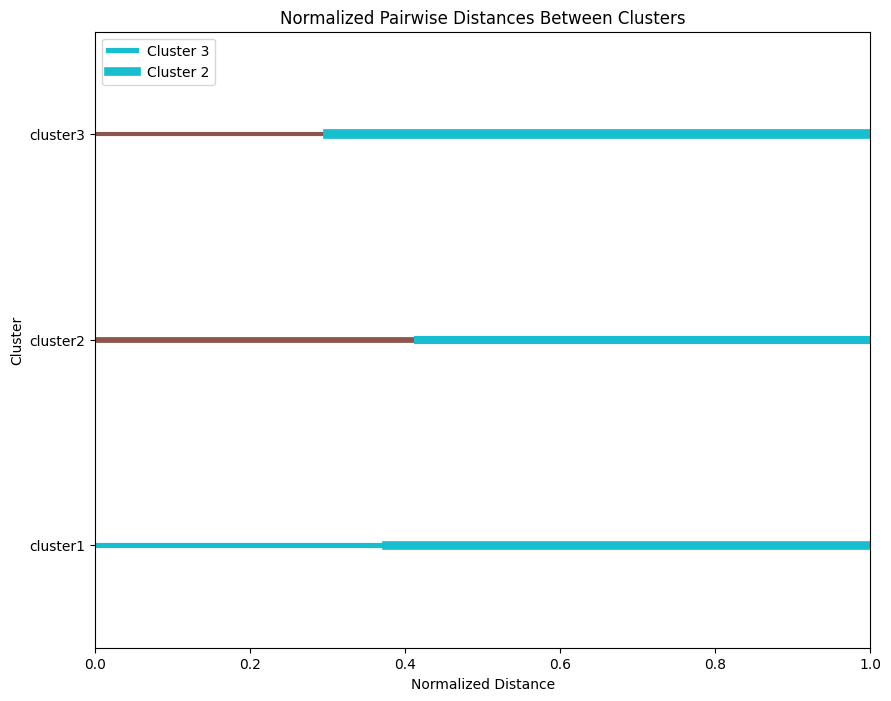

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_normalized_distances(pairwise_dict):
    # Define the color map (optional, you can choose any other color palette)
    num_clusters = len(pairwise_dict)
    color_map = plt.cm.get_cmap("tab10", num_clusters)

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Iterate through each cluster to plot its normalized distances
    for y, (cluster, distances) in enumerate(pairwise_dict.items(), start=1):
        # Total length of x-axis is 1, divide it into segments based on normalized distances
        sorted_items = list(distances.items())  # Convert the sub-dictionary to a list of tuples
        segments = np.cumsum([item[1] for item in sorted_items])  # Cumulative sum of normalized distances
        segments = np.insert(segments, 0, 0)  # Insert 0 at the start for the first segment

        # Plot each line segment for this cluster
        for i, (sub_cluster, distance) in enumerate(sorted_items):
            ax.plot([segments[i], segments[i+1]], [y, y], color=color_map(sub_cluster), lw=distance*10, label=f"Cluster {sub_cluster}" if y == 1 else "")

    # Adding labels and title
    ax.set_xlabel('Normalized Distance')
    ax.set_ylabel('Cluster')
    ax.set_title('Normalized Pairwise Distances Between Clusters')
    ax.set_ylim(0.5, num_clusters + 0.5)
    ax.set_xlim(0, 1)

    # Hide the y-axis tick labels and show only cluster numbers as ticks
    ax.set_yticks(range(1, num_clusters + 1))  # Only display ticks for clusters
    ax.set_yticklabels(['cluster' + str(i) for i in range(1, num_clusters + 1)])  # Display cluster numbers as y-tick labels

    # Remove duplicate labels in the legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left')

    # Show the plot
    plt.show()

# Example pairwise dictionary
pairwise_dict = {
    1: {2: 0.5, 3: 0.3},
    2: {1: 0.5, 3: 0.7},
    3: {1: 0.3, 2: 0.7}
}

# Normalize and sort the pairwise dictionary (if needed)
normalized_sorted_pairwise_dict = normalize_and_sort_pairwise_dict(pairwise_dict)

# Plot the normalized distances
plot_normalized_distances(normalized_sorted_pairwise_dict)


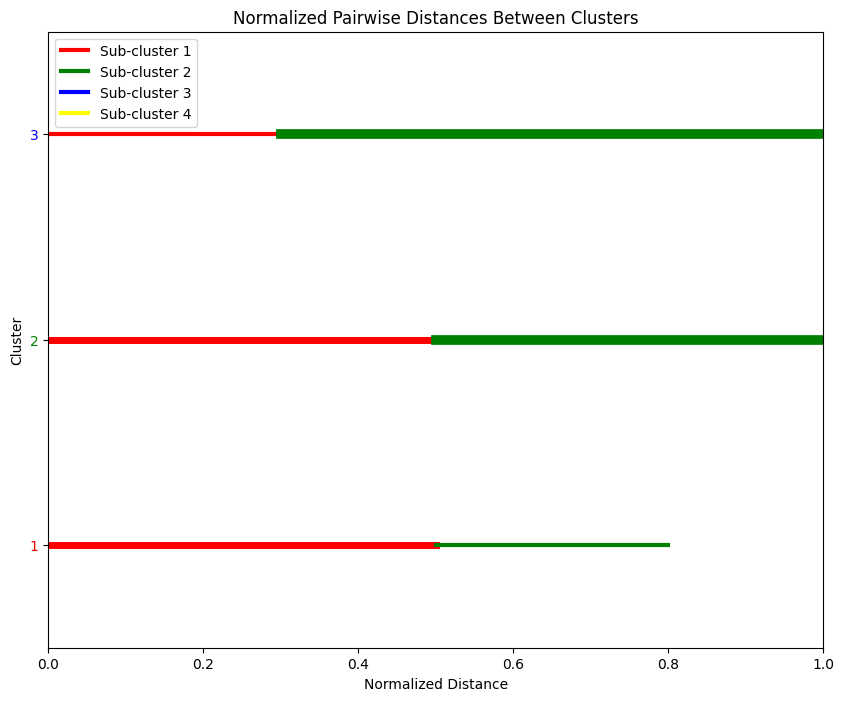

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_normalized_distances_with_custom_colors(pairwise_dict, color_list):
    num_clusters = len(pairwise_dict)

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Ensure color_list is long enough to cover all sub-clusters
    if len(color_list) < max(len(d) for d in pairwise_dict.values()):
        raise ValueError("color_list must have at least as many colors as the maximum number of sub-clusters.")

    # Iterate through each cluster to plot its normalized distances
    for y, (cluster, distances) in enumerate(pairwise_dict.items(), start=1):
        # Total length of x-axis is 1, divide it into segments based on normalized distances
        sorted_items = list(distances.items())  # Convert the sub-dictionary to a list of tuples
        segments = np.cumsum([item[1] for item in sorted_items])  # Cumulative sum of normalized distances
        segments = np.insert(segments, 0, 0)  # Insert 0 at the start for the first segment

        # Plot each line segment for this cluster with the corresponding color from the sub-cluster keys
        for i, (sub_cluster, distance) in enumerate(sorted_items):
            # Choose color from the color_list based on the sub-cluster key
            segment_color = color_list[i % len(color_list)]  # Ensure it wraps around if there are more sub-clusters than colors

            # Plot segment using the color corresponding to the sub-cluster
            ax.plot([segments[i], segments[i+1]], [y, y], color=segment_color, lw=distance*10, label=f"Sub-cluster {sub_cluster}" if y == 1 else "")

    # Adding labels and title
    ax.set_xlabel('Normalized Distance')
    ax.set_ylabel('Cluster')
    ax.set_title('Normalized Pairwise Distances Between Clusters')
    ax.set_ylim(0.5, num_clusters + 0.5)
    ax.set_xlim(0, 1)

    # Set y-ticks to show only cluster numbers, color them based on cluster index but without segment color
    ax.set_yticks(range(1, num_clusters + 1))  # Only display ticks for clusters
    ax.set_yticklabels([str(i) for i in range(1, num_clusters + 1)])  # Display cluster numbers as y-tick labels
    for i, tick in enumerate(ax.get_yticklabels()):
        tick.set_color(color_list[i])  # Set color of y-tick labels according to color_list (based on clusters)

    # Add color legend to show which color corresponds to which sub-cluster
    patches = [plt.Line2D([0], [0], color=color_list[i], lw=3) for i in range(len(color_list))]
    ax.legend(patches, [f"Sub-cluster {i+1}" for i in range(len(color_list))], loc='upper left')

    # Show the plot
    plt.show()

# Example pairwise dictionary with sub-clusters (values are normalized distances)
pairwise_dict = {
    1: {2: 0.5, 3: 0.3},
    2: {1: 0.5, 3: 0.7},
    3: {1: 0.3, 2: 0.7}
}

# Custom color list for sub-clusters (not for clusters themselves)
color_list = ['red', 'green', 'blue', 'yellow']

# Plot the normalized distances with the custom colors
plot_normalized_distances_with_custom_colors(pairwise_dict, color_list)


In [42]:
x = np.array([0.21, 0.28,  0.51])
y = np.array([0.18, 0.29, 0.53])

# z = np.abs(x - y)
z = np.abs(x + y)
z

array([0.39, 0.57, 1.04])

In [44]:
z/np.sum(z)
# x = np.array([0.27, 0.28,  0.45])
# sum(x)


array([0.195, 0.285, 0.52 ])

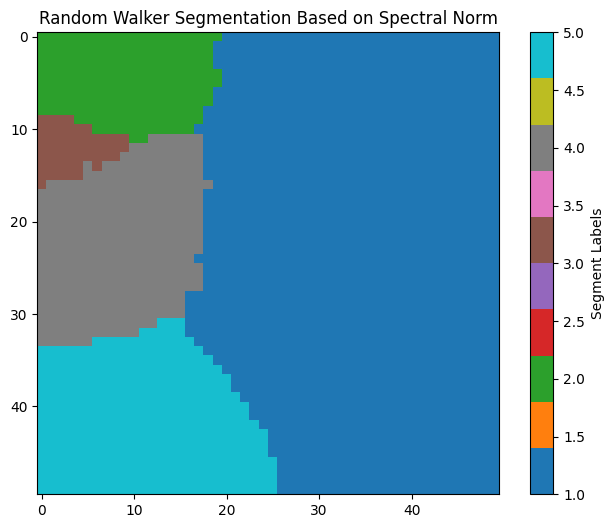

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import random_walker
from skimage.morphology import remove_small_objects

def segment_with_random_walker(norm_values, num_seeds=10, threshold=0.8):
    """
    Segments a 2D space using random walker algorithm based on Jacobian norm values.
    
    Parameters:
    - norm_values: 2D NumPy array of Jacobian norm values.
    - num_seeds: Number of random seed points.
    - threshold: Threshold to define decision boundaries (high norm values).
    
    Returns:
    - segmented_grid: 2D NumPy array with segment labels.
    """
    grid_shape = norm_values.shape

    # Identify boundary (high-norm) regions
    boundary_mask = norm_values > threshold  

    # Initialize label grid: 0 = unlabeled, 1-N = segment labels
    labels = np.zeros(grid_shape, dtype=int)

    # Find valid (non-boundary) regions
    valid_points = np.argwhere(~boundary_mask)

    # Randomly select seed points inside valid regions
    np.random.seed(42)  # For reproducibility
    if len(valid_points) < num_seeds:
        num_seeds = len(valid_points)  # Adjust if too few points

    selected_seeds = valid_points[np.random.choice(len(valid_points), num_seeds, replace=False)]

    # Assign unique labels to seed points
    for i, (x, y) in enumerate(selected_seeds):
        labels[x, y] = i + 1  # Assign unique labels

    # Perform random walker segmentation
    segmented_grid = random_walker(norm_values, labels, beta=10, mode='bf')

    # Remove small noisy segments
    segmented_grid = remove_small_objects(segmented_grid, min_size=5)

    return segmented_grid

# Example usage
np.random.seed(42)
grid_size = (50, 50)
jacob_norm = np.random.rand(*grid_size)  # Simulated Jacobian norm values

segmented_grid = segment_with_random_walker(jacob_norm, num_seeds=5, threshold=0.7)

# Plot results
plt.figure(figsize=(8, 6))
plt.imshow(segmented_grid, cmap='tab10', interpolation='nearest')
plt.colorbar(label="Segment Labels")
plt.title("Random Walker Segmentation Based on Spectral Norm")
plt.show()


Max Edge: (np.int32(26), np.int32(69), np.float64(0.580988404906314))


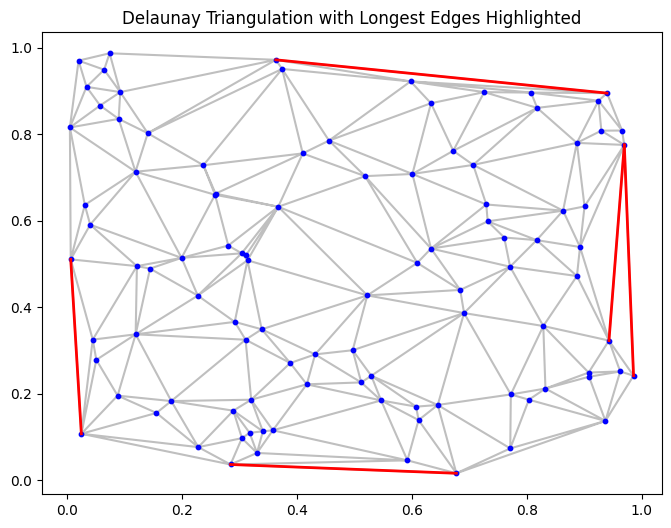

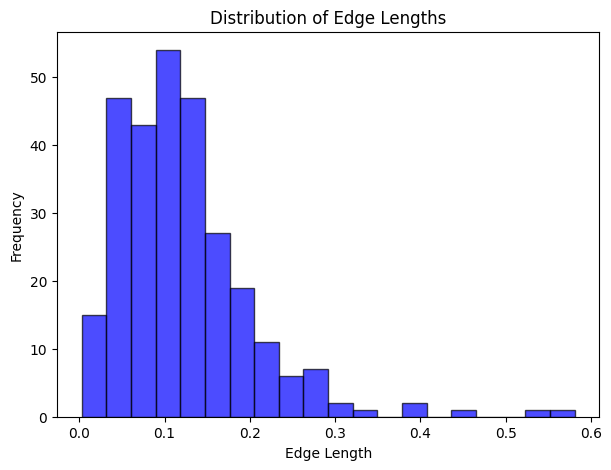

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial

# Sample t-SNE output (replace with actual data)
np.random.seed(42)
tsne_2d = np.random.rand(100, 2)  # Replace with your t-SNE data (N x 2)

# Compute Delaunay triangulation
tri = scipy.spatial.Delaunay(tsne_2d)

# Extract edges
edges = set()
for simplex in tri.simplices:
    for i in range(3):  # Each triangle has 3 edges
        edges.add(tuple(sorted([simplex[i], simplex[(i+1) % 3]])))

# Compute edge lengths
edge_lengths = [(i, j, np.linalg.norm(tsne_2d[i] - tsne_2d[j])) for i, j in edges]
edge_lengths.sort(key=lambda x: x[2], reverse=True)  # Sort by length

# Find max edge length
max_edge = edge_lengths[0]
print(f"Max Edge: {max_edge}")

# Visualization
plt.figure(figsize=(8, 6))
plt.triplot(tsne_2d[:, 0], tsne_2d[:, 1], tri.simplices, color='gray', alpha=0.5)
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], s=10, color='blue')

# Highlight longest edges
for i, j, length in edge_lengths[:5]:  # Highlight top 5 longest edges
    plt.plot([tsne_2d[i, 0], tsne_2d[j, 0]], [tsne_2d[i, 1], tsne_2d[j, 1]], 'r-', linewidth=2)

plt.title("Delaunay Triangulation with Longest Edges Highlighted")
plt.show()

# Histogram of edge lengths
lengths = [l[2] for l in edge_lengths]
plt.figure(figsize=(7, 5))
plt.hist(lengths, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.xlabel("Edge Length")
plt.ylabel("Frequency")
plt.title("Distribution of Edge Lengths")
plt.show()

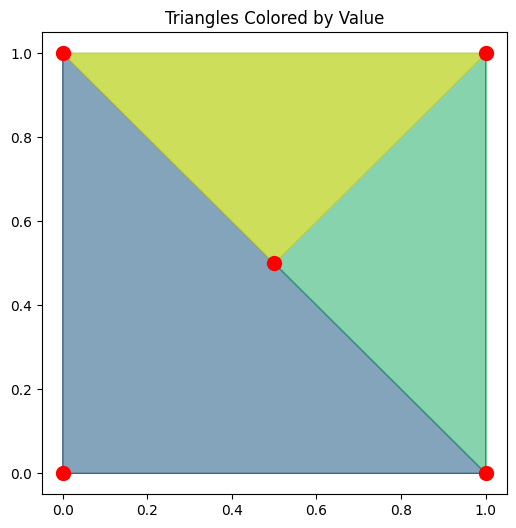

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Example: Define some points in 2D space
x = np.array([0, 1, 0, 1, 0.5])
y = np.array([0, 0, 1, 1, 0.5])

# Example: Triangles formed by the points (indices into x and y)
triangles = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 4]])

# Create the triangulation object
triang = tri.Triangulation(x, y, triangles)

# Example values for each triangle (e.g., max edge length, area, etc.)
# This should be an array of length equal to the number of triangles
triangle_values = np.array([1, 2, 3])  # Length must match the number of triangles

# Ensure the triangle values are the same length as the number of triangles
assert len(triangle_values) == len(triang.triangles), "Length of triangle_values must match the number of triangles"

# Manually check the triangulation by plotting with triplot
plt.figure(figsize=(6, 6))
plt.triplot(triang, color='k', lw=0.5)  # Show the triangles as a plot

# Scatter plot to show values for each triangle
plt.scatter(x, y, c='r', s=100, zorder=10)  # Show points for context

# Now, manually color each triangle using a scatter plot (basic contour-like coloring)
for i, t in enumerate(triang.triangles):
    # Get the triangle vertices
    triangle_coords = np.array([[x[t[0]], y[t[0]]],
                                [x[t[1]], y[t[1]]],
                                [x[t[2]], y[t[2]]]])

    # Plot each triangle with the associated value (e.g., triangle_values[i])
    plt.fill(triangle_coords[:, 0], triangle_coords[:, 1], color=plt.cm.viridis(triangle_values[i] / max(triangle_values)), alpha=0.6)

plt.title("Triangles Colored by Value")
plt.show()


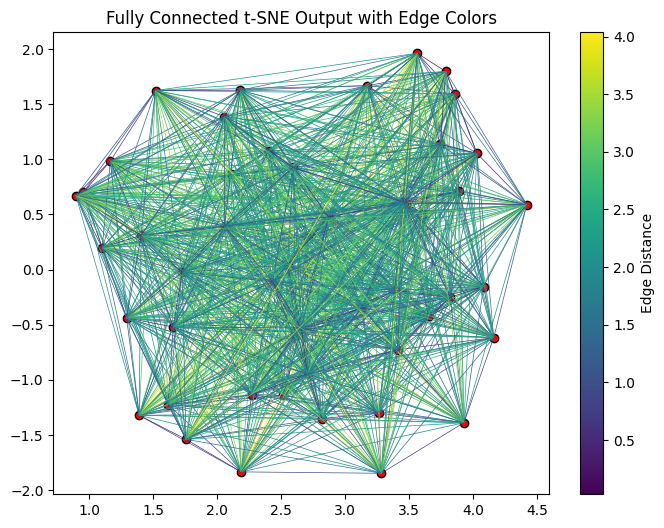

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.collections import LineCollection
import itertools

# Generate synthetic high-dimensional data
np.random.seed(0)
X = np.random.rand(50, 10)  # 50 points in 10D

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_2D = tsne.fit_transform(X)  # Output is a 2D embedding

# Generate all possible edges
edges = list(itertools.combinations(range(len(X_2D)), 2))  # All point pairs

# Define edge colors based on some property (e.g., Euclidean distance)
edge_weights = [np.linalg.norm(X_2D[i] - X_2D[j]) for i, j in edges]

# Normalize and map to colormap
cmap = plt.get_cmap("viridis")
norm = plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))
edge_colors = [cmap(norm(w)) for w in edge_weights]

# Create line segments
line_segments = [(X_2D[i], X_2D[j]) for i, j in edges]

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(X_2D[:, 0], X_2D[:, 1], color="red", zorder=2, edgecolors="black", label="t-SNE Points")

# Add colored edges
lc = LineCollection(line_segments, colors=edge_colors, linewidths=0.5)
ax.add_collection(lc)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Edge Distance")

plt.title("Fully Connected t-SNE Output with Edge Colors")
plt.show()


In [20]:
import numpy as np

# Example edge lengths in High Dim (HD) and Low Dim (LD)
edge_lengths_HD = np.array([2, 1, 3, 4])  # Unsorted HD lengths
edge_lengths_LD = np.array([2, 3, 4, 1])  # Corresponding LD lengths
# edge_lengths_LD = np.array([2, 1, 3, 4])  # Corresponding LD lengths

# Sort HD and store indices
sorted_indices_HD = np.argsort(edge_lengths_HD)  # Indices after sorting HD

#Sort LD and store indices
sorted_indices_LD = np.argsort(edge_lengths_LD)  # Indices after sorting LD

#  
# sorted_indices = np.argsort(sorted_indices_LD)
# positions = np.searchsorted(sorted_indices_LD[sorted_indices], sorted_indices_HD)
# positions = np.searchsorted(sorted_indices_LD, sorted_indices_HD)

matching_indices = [np.where(sorted_indices_LD == val)[0] for val in sorted_indices_HD]

# sorted_array = np.sort(array)  # Ensure it's sorted
# positions = np.searchsorted(sorted_array, indices)

# 
# final_positions = sorted_indices_LD[positions]


# Print results
print("Original HD lengths:", edge_lengths_HD)
print("Sorted Indices HD:", sorted_indices_HD)
print("Sorted Indices LD:", sorted_indices_LD)

print("Positions of sorted_indices_HD elements in sorted_indices_LD:", matching_indices)

Original HD lengths: [2 1 3 4]
Sorted Indices HD: [1 0 2 3]
Sorted Indices LD: [3 0 1 2]
Positions of sorted_indices_HD elements in sorted_indices_LD: [array([2]), array([1]), array([3]), array([0])]


In [7]:
sorted_indices_HD

array([1, 0, 3, 2])

In [25]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.widgets import RectangleSelector

# Step 1: Generate Sample Data
np.random.seed(42)
num_samples = 300
num_features = 50  # Assume original data has 50 features
num_classes = 3

# Create random data and assign class labels (0, 1, 2)
original_data = np.random.rand(num_samples, num_features)
labels = np.random.choice(num_classes, num_samples)  # Randomly assign classes

# Step 2: Apply t-SNE for 2D projection
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(original_data)

# Step 3: Plot the t-SNE-transformed data
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap="viridis", alpha=0.7)
ax.set_title("t-SNE Projection of Data")

# Interactive Selection Storage
selected_indices_1 = []
selected_indices_2 = []

def onselect(eclick, erelease, box_id):
    """Handle the selection of points inside the drawn box."""
    global selected_indices_1, selected_indices_2

    xmin, xmax = sorted([eclick.xdata, erelease.xdata])
    ymin, ymax = sorted([eclick.ydata, erelease.ydata])

    # Find points inside the box
    selected = np.where(
        (tsne_results[:, 0] >= xmin) & (tsne_results[:, 0] <= xmax) &
        (tsne_results[:, 1] >= ymin) & (tsne_results[:, 1] <= ymax)
    )[0]

    # Store selected points in separate lists for two different selections
    if box_id == 1:
        selected_indices_1 = selected
    elif box_id == 2:
        selected_indices_2 = selected

    print(f"Selected {len(selected)} points for Box {box_id}.")

# Create two rectangle selectors for two different classes
rect_selector_1 = RectangleSelector(ax, lambda eclick, erelease: onselect(eclick, erelease, 1),
                                    useblit=True, interactive=True, props=dict(facecolor='red', alpha=0.3))


rect_selector_2 = RectangleSelector(ax, lambda eclick, erelease: onselect(eclick, erelease, 2),
                                    useblit=True, interactive=True, props=dict(facecolor='blue', alpha=0.3))


plt.show()

# Step 4: Extract selected points from the original dataset
selected_class_1 = original_data[selected_indices_1]
selected_class_2 = original_data[selected_indices_2]

# Print summary
print(f"Class 1: {len(selected_class_1)} points extracted.")
print(f"Class 2: {len(selected_class_2)} points extracted.")


RuntimeError: 'widget is not a recognised GUI loop or backend name

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances

# Sample data (Each row is a point, last column is the class label)
data = np.array([
    [1.0, 2.0, 0],  # Class 0
    [1.2, 2.1, 0],  # Class 0
    [5.0, 6.0, 1],  # Class 1
    [5.2, 6.1, 1],  # Class 1
    [9.0, 10.0, 2], # Class 2
    [9.3, 10.2, 2]  # Class 2
])

# Split features and labels
X = data[:, :-1]  # Features (first columns)
labels = data[:, -1]  # Class labels (last column)

# Compute the full distance matrix
distance_matrix = pairwise_distances(X, metric='euclidean')

# Create a DataFrame for better visualization
df_distances = pd.DataFrame(distance_matrix, columns=[f"Point {i}" for i in range(len(X))], index=[f"Point {i}" for i in range(len(X))])

# Identify intra-class and inter-class distances
intra_class_mask = np.zeros_like(distance_matrix, dtype=bool)
inter_class_mask = np.zeros_like(distance_matrix, dtype=bool)

for i in range(len(X)):
    for j in range(len(X)):
        if labels[i] == labels[j]:
            intra_class_mask[i, j] = True  # Same class → intra-class
        else:
            inter_class_mask[i, j] = True  # Different class → inter-class

# Extract intra-class distances
intra_class_distances = distance_matrix[intra_class_mask].reshape(len(X), -1)

# Extract inter-class distances
inter_class_distances = distance_matrix[inter_class_mask].reshape(len(X), -1)

# Display results
print("📌 Distance Matrix:\n", df_distances)
print("\n📌 Intra-Class Distances:\n", intra_class_distances)
print("\n📌 Inter-Class Distances:\n", inter_class_distances)

# Visualize the Distance Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_distances, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Pairwise Distance Matrix (Intra & Inter-Class)")
plt.show()


📌 Distance Matrix:
            Point 0    Point 1   Point 2   Point 3    Point 4    Point 5
Point 0   0.000000   0.223607  5.656854  5.869412  11.313708  11.667476
Point 1   0.223607   0.000000  5.445181  5.656854  11.101802  11.455130
Point 2   5.656854   5.445181  0.000000  0.223607   5.656854   6.010824
Point 3   5.869412   5.656854  0.223607  0.000000   5.445181   5.798276
Point 4  11.313708  11.101802  5.656854  5.445181   0.000000   0.360555
Point 5  11.667476  11.455130  6.010824  5.798276   0.360555   0.000000

📌 Intra-Class Distances:
 [[0.         0.2236068 ]
 [0.2236068  0.        ]
 [0.         0.2236068 ]
 [0.2236068  0.        ]
 [0.         0.36055513]
 [0.36055513 0.        ]]

📌 Inter-Class Distances:
 [[ 5.65685425  5.86941224 11.3137085  11.66747616]
 [ 5.44518136  5.65685425 11.10180166 11.45512986]
 [ 5.65685425  5.44518136  5.65685425  6.01082357]
 [ 5.86941224  5.65685425  5.44518136  5.79827561]
 [11.3137085  11.10180166  5.65685425  5.44518136]
 [11.66747616 11

<IPython.core.display.Javascript object>

In [27]:
def inter_intra_cluster_pairwise_distance(data, labels, unique_clusters, metric='euclidean', norm_distance=False, norm_type='global'):
    
    num_clusters = len(unique_clusters)
    unique_clusters = np.sort(unique_clusters)

    # Initialize storage
    pairwise_distances_dict = {}  
    mean_pairwise_distances_matrix = np.zeros((num_clusters, num_clusters))

    # breakpoint()
    for i, cluster_i in enumerate(unique_clusters):
        cluster_i_points = data[labels == cluster_i]

        for j, cluster_j in enumerate(unique_clusters):
            if j < i:  
                continue  # Skip lower triangle, will be filled from (i, j)

            cluster_j_points = data[labels == cluster_j]

            # Compute pairwise distances
            inter_cluster_distances = pairwise_distances(cluster_i_points, cluster_j_points, metric=metric)
            # inter_cluster_distances_2 = pairwise_distances(cluster_j_points, cluster_i_points, metric=metric)
            # diff = inter_cluster_distances - inter_cluster_distances_2
            # breakpoint()
            # Store distance matrix in both directions
            pairwise_distances_dict[(i, j)] = inter_cluster_distances
            if i != j:  
                pairwise_distances_dict[(j, i)] = inter_cluster_distances.T  # True symmetry

            # Store mean distances
            mean_distance = np.mean(inter_cluster_distances)
            mean_pairwise_distances_matrix[i, j] = mean_distance
            if i != j:  
                mean_pairwise_distances_matrix[j, i] = mean_distance  # True symmetry

    # Convert to full pairwise matrix
    row_blocks = []
    for i in range(num_clusters):
        row = [pairwise_distances_dict[(i, j)] for j in range(num_clusters)]
        row_blocks.append(np.hstack(row))  

    full_pairwise_distance_matrix = np.vstack(row_blocks)

    # Normalization if required
    if norm_distance:
        min_value = np.min(full_pairwise_distance_matrix)
        max_value = np.max(full_pairwise_distance_matrix)
        full_pairwise_distance_matrix = (full_pairwise_distance_matrix - min_value) / (max_value - min_value)

        min_value_mean = np.min(mean_pairwise_distances_matrix)
        max_value_mean = np.max(mean_pairwise_distances_matrix)
        mean_pairwise_distances_matrix = (mean_pairwise_distances_matrix - min_value_mean) / (max_value_mean - min_value_mean)
    # if norm_distance:
    #     min_value = np.min(full_pairwise_distance_matrix)
    #     max_value = np.max(full_pairwise_distance_matrix)
    #     min_value_mean = np.min(mean_pairwise_distances_matrix)
    #     max_value_mean = np.max(mean_pairwise_distances_matrix)

    #     full_pairwise_distance_matrix = (full_pairwise_distance_matrix - min_value_mean) / (max_value_mean - min_value_mean)
    #     mean_pairwise_distances_matrix = (mean_pairwise_distances_matrix - min_value_mean) / (max_value_mean - min_value_mean)

    return full_pairwise_distance_matrix, mean_pairwise_distances_matrix


In [28]:
import numpy as np
import pandas as pd

# Define the dataset
data = np.array([
    [5.1, 3.5, 1.4, 0.2, 0],  # Class 0
    [4.9, 3.0, 1.4, 0.2, 0],
    [4.7, 3.2, 1.3, 0.2, 0],
    [4.6, 3.1, 1.5, 0.2, 0],
    [5.0, 3.6, 1.4, 0.2, 0],
    
    [6.3, 3.3, 4.7, 1.6, 1],  # Class 1
    [6.1, 2.9, 4.7, 1.4, 1],
    [6.4, 3.2, 4.5, 1.5, 1],
    [6.6, 2.9, 4.6, 1.3, 1],
    [6.8, 3.0, 4.9, 1.5, 1],
    
    [7.1, 3.0, 6.1, 2.3, 2],  # Class 2
    [6.3, 3.4, 5.6, 2.4, 2],
    [6.5, 3.0, 5.8, 2.2, 2],
    [7.6, 3.0, 6.6, 2.1, 2],
    [7.3, 2.9, 6.3, 1.8, 2]
])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Feature1", "Feature2", "Feature3", "Feature4", "Class"])

# Convert class labels to integers
df["Class"] = df["Class"].astype(int)

# Display the dataset
print(df)


    Feature1  Feature2  Feature3  Feature4  Class
0        5.1       3.5       1.4       0.2      0
1        4.9       3.0       1.4       0.2      0
2        4.7       3.2       1.3       0.2      0
3        4.6       3.1       1.5       0.2      0
4        5.0       3.6       1.4       0.2      0
5        6.3       3.3       4.7       1.6      1
6        6.1       2.9       4.7       1.4      1
7        6.4       3.2       4.5       1.5      1
8        6.6       2.9       4.6       1.3      1
9        6.8       3.0       4.9       1.5      1
10       7.1       3.0       6.1       2.3      2
11       6.3       3.4       5.6       2.4      2
12       6.5       3.0       5.8       2.2      2
13       7.6       3.0       6.6       2.1      2
14       7.3       2.9       6.3       1.8      2


In [1]:
import numpy as np
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Define Points and Triangulation
# ---------------------------
points = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1]
])
tri = Delaunay(points)

# ---------------------------
# Step 2: Query Point Inside
# ---------------------------
P = np.array([0.25, 0.25])

# Find the triangle that contains P
simplex = tri.find_simplex(P)

if simplex == -1:
    raise ValueError("Point lies outside the triangulation.")

# ---------------------------
# Step 3: Extract Vertices of Triangle
# ---------------------------
vertices = tri.simplices[simplex]        # indices of triangle vertices
T = points[vertices]                     # coordinates of triangle vertices
A, B, C = T[0], T[1], T[2]

# ---------------------------
# Step 4: Compute Barycentric Coordinates
# ---------------------------
def barycentric_coords(P, A, B, C):
    v0 = B - A
    v1 = C - A
    v2 = P - A

    d00 = np.dot(v0, v0)
    d01 = np.dot(v0, v1)
    d11 = np.dot(v1, v1)
    d20 = np.dot(v2, v0)
    d21 = np.dot(v2, v1)

    denom = d00 * d11 - d01 * d01
    v = (d11 * d20 - d01 * d21) / denom
    w = (d00 * d21 - d01 * d20) / denom
    u = 1.0 - v - w

    return u, v, w

l1, l2, l3 = barycentric_coords(P, A, B, C)

# ---------------------------
# Step 5: Validation
# ---------------------------
print(f"Barycentric Coords of P wrt triangle {A, B, C}:")
print(f"  λ1 = {l1:.3f}, λ2 = {l2:.3f}, λ3 = {l3:.3f}")
print(f"  Sum = {l1 + l2 + l3:.3f}")


Barycentric Coords of P wrt triangle (array([1, 1]), array([0, 1]), array([0, 0])):
  λ1 = 0.250, λ2 = 0.000, λ3 = 0.750
  Sum = 1.000


In [4]:
T

array([[1, 1],
       [0, 1],
       [0, 0]])